## Machine Translation (Seq2Seq) with Attention

In [ ]:
# !pip install -U torchtext==0.6.0

In [1]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

1.10.0+cu102
0.6.0


### Import Libraries

In [2]:
import spacy
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


from torchtext.datasets import Multi30k
from torchtext.data.metrics import bleu_score 
from torchtext.data import Field, BucketIterator

### Tokenizers

In [3]:
# !python -m spacy download de
# # de_core_news_sm
# !python -m spacy download en_core_web_sm

In [4]:
spacy_ger = spacy.load("de_core_news_sm")
spacy_eng = spacy.load("en_core_web_sm")

# German Tokenizer
def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]

# English Tokenizer
def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

### Import Data & Build Vocabulary

In [5]:
# Creating fields for both languages while importing data
german = Field(
    tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>"
)

english = Field(
    tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

# Importing data and splitting in train, test and validation splits
train_data, valid_data, test_data =Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

print(type(train_data))

# Building the vocabulary
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

<class 'torchtext.datasets.translation.Multi30k'>


In [6]:
print(f"Unique tokens in German vocabulary: {len(german.vocab)}")
print(f"Unique tokens in English vocabulary: {len(english.vocab)}")

print('\n')
print(f"Length of Training Data: {len(train_data)}")
print(f"Length of Vaidation Data: {len(valid_data)}")
print(f"Length of Testing Data: {len(test_data)}")

Unique tokens in German vocabulary: 7853
Unique tokens in English vocabulary: 5893


Length of Training Data: 29000
Length of Vaidation Data: 1014
Length of Testing Data: 1000


### Models 
#### Encoder, Decoder and Seq2Seq(Combine)

In [7]:
# First LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size) # 2 from Bidirectional and 1 as input to Decoder
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.lstm(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # We use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional and will take one input

        # Before hidden shape: (2, N, hidden_size) (We concatenate this dimension and pass through hiden layer)
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2)) # Concatenating the Forward and Backward hiden states from Bidirectional
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [8]:
# 2nd LSTM
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)

        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)

        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)

        # attention: (seq_length, N, 1), snk
        # encoder_states: (seq_length, N, hidden_size*2), snl
        # we want context_vector: (1, N, hidden_size*2), i.e knl
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [9]:
# Here we combine both models in one model called Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1] # N
        target_len = target.shape[0] # Max sequence length
        target_vocab_size = len(english.vocab) # English Vocab (Over which we will have Softmax)

        # Creating empty outputs
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # x shape (1,N) where N is the batch size
        x = target[0]

        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Model and Training Hyperparameters

In [11]:
# Training hyperparameters
num_epochs = 50
learning_rate = 0.001
batch_size = 64

# Model hyperparameters
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
enc_dropout = 0.3
dec_dropout = 0.3

## Models, Optimizer and Data Iterator

In [12]:
# Data Iterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

# Models
encoder_net = Encoder(
    input_size_encoder, 
    encoder_embedding_size, 
    hidden_size, 
    num_layers, 
    enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)


# Combine Models
model = Seq2Seq(encoder_net, decoder_net).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss
pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

### Getting Translated Prediction

In [13]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # Load german tokenizer
    spacy_ger = spacy.load("de_core_news_sm")
    # spacy.load("de")

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        outputs_encoder, hiddens, cells = model.encoder(sentence_tensor)

    # Adding <sos> as start of output
    outputs = [english.vocab.stoi["<sos>"]] 

    # Predicting best translation for each word till we get <eos> tag
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hiddens, cells = model.decoder(
                previous_word, outputs_encoder, hiddens, cells
            )
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]


### BLEU Score

In [14]:
# Getting BLEU score for translated prediction
def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)



# Next, we have a small function that tells us how long an epoch takes.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



# Saving and loading checkpoints
################################


# load_model = False
# save_model = False

# def load_checkpoint(checkpoint, model, optimizer):
#     print("=> Loading checkpoint")
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])
    
# def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
#     torch.save(state, filename)
    
    
# if load_model:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


# Save checkpoint within loop if required

#     if save_model:
#         checkpoint = {
#             "state_dict": model.state_dict(),
#             "optimizer": optimizer.state_dict(),
#         }
#         save_checkpoint(checkpoint)

### Training

In [16]:
print("German Sentence: \n ein boot mit mehreren männern darauf wird von einem großen.")
print("English Translation: \n a boat with several men on it is being driven by a big one.")

German Sentence: 
 ein boot mit mehreren männern darauf wird von einem großen.
English Translation: 
 a boat with several men on it is being driven by a big one.


In [17]:
step = 0

sentence = (
    "ein boot mit mehreren männern darauf wird von einem großen."
)

trainingLoss = []

for epoch in range(num_epochs):
    print(f"[Epoch {epoch + 1} / {num_epochs}]")
    print('-'*20)

    model.eval()

    # Checking model performance at each epoch for sentence.
    translated_sentence = translate_sentence(
        model, sentence, german, english, device, max_length=50
    )
    print(f"Translated example sentence: \n {translated_sentence}")
    
    
    
    # Start Time
    start_time = time.time()
    
    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        # Forward prop (Sending batches to model)
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. 
        
        
        # For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        trainingLoss.append(loss)
        step += 1
    
    # End Time
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {loss:.3f}')

[Epoch 1 / 50]
--------------------
Translated example sentence: 
 ['handrail', 'dad', 'text', 'hits', 'wife', 'peacock', 'peacock', 'peacock', 'bookshelf', 'descent', 'pineapples', 'vehicles', 'tattered', 'africans', 'elaborate', 'shouts', 'rooster', 'shingles', 'bench', 'mallet', 'african', 'ponytail', 'yawning', 'stump', 'cyclists', 'gear', 'crafts', 'eyeglasses', 'dotted', 'within', 'poodle', 'ollie', 'ollie', 'person', 'london', 'america', 'playpen', 'swan', 'header', 'darth', 'rice', 'lost', 'scaffolds', 'falcon', 'recycling', 'exercise', 'lavender', 'hillside', 'champagne', 'karate']
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 3.886
[Epoch 2 / 50]
--------------------
Translated example sentence: 
 ['a', 'young', 'is', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '.', '<eos>']
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 2.955
[Epoch 3 / 50]
--------------------
Translated example sentence: 
 ['a', 'construction', 'worker', 'with', 'a', 'large', 'of', 'of', 'people', 'are', 'by', 'a', '.',

In [20]:
sentence = (
   "Der schnelle braune Fuchs sprang über den faulen Hund"
)


translated_sentence = translate_sentence(
    model, sentence, german, english, device, max_length=50
)

print("Predicted Answer: {}".format(" ".join(translated_sentence) ))

print("Golden Answer: The quick brown fox jumped over the lazy dog")

Predicted Answer: the elaborate dog <unk> dog <unk> across the gray dog . <eos>
Golden Answer: The quick brown fox jumped over the lazy dog


In [21]:
# Runnning on subset of test set
score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score * 100:.2f}")

Bleu score 22.99


In [43]:
Losses = [a.item() for a in trainingLoss] # Convert from tensor to list

remainder = len(Losses)/num_epochs
LossFinal = [v for i, v in enumerate(Losses) if i%remainder == 0]
LossFinal[:5]

[8.68491268157959,
 3.781982898712158,
 2.588346242904663,
 2.497600555419922,
 2.0057930946350098]

### Visualization of results

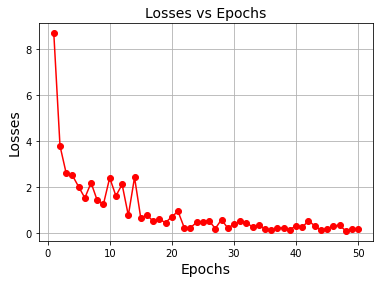

In [45]:
import numpy as np
import matplotlib.pyplot as plta

Epochs = list(np.arange(1,num_epochs+1))

plt.plot(Epochs, LossFinal, color='red', marker='o')
plt.title('Losses vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Losses', fontsize=14)
plt.grid(True)
plt.show()

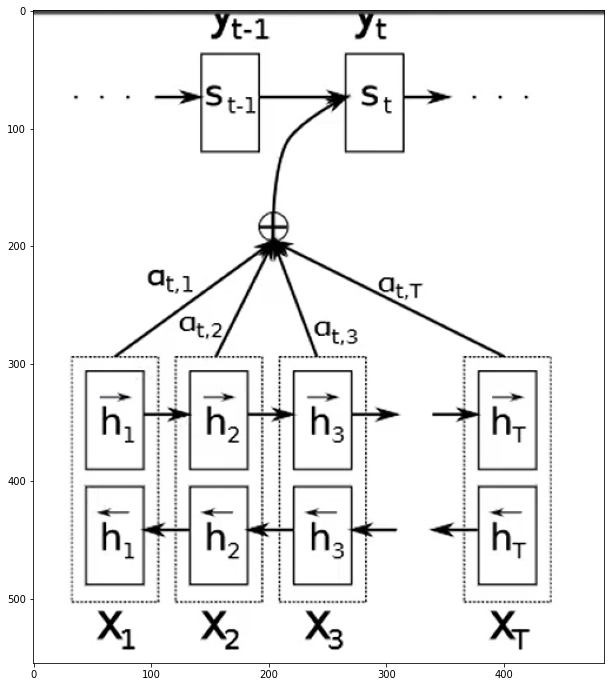

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def showImage(x):    
    plt.figure(figsize=(20,12))
    img = mpimg.imread(str(x) + '.PNG')
    plt.imshow(img)
showImage('Architecture')

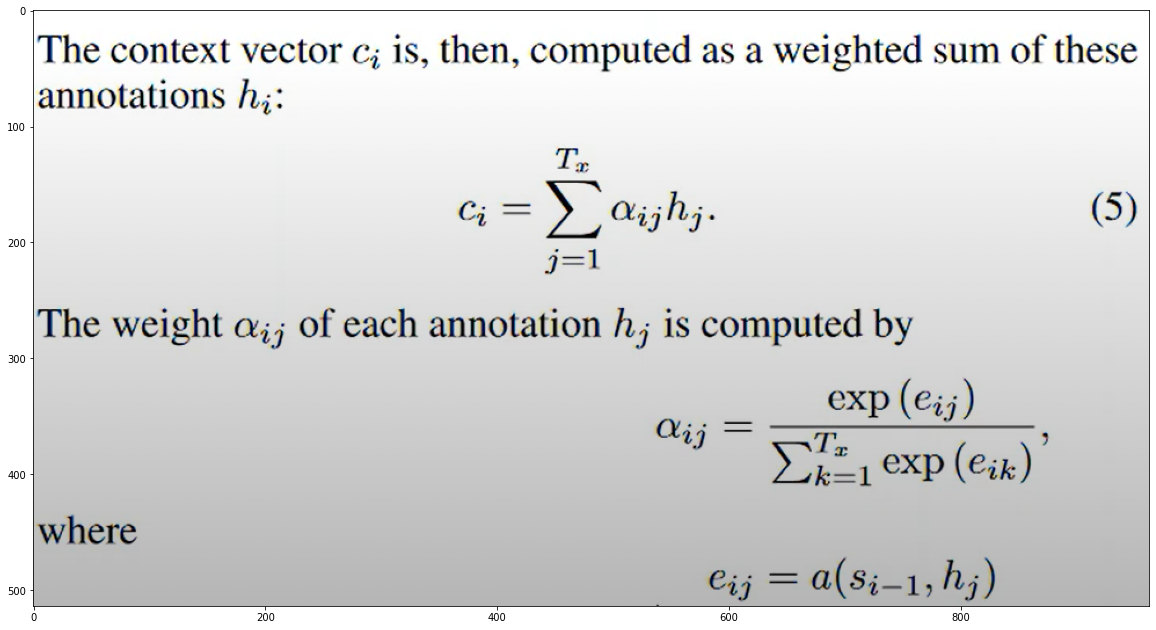

In [4]:
showImage('Math')

### Technique Details

Here we use and Encoder decoder architecture to translate from one language to another. The model we will use is a Seq2Seq one where we you Bidirectional LSTM in our encoder with attention which feeds into the decoder or single lstm to give predictions using softmax at each state. In this many to many architecture the number of inputs are not equal to the number of outputs. We use ReLU as activation function to calculate the energies and then pass it on to softmax to get attention weights. Convex combination is then taken as a result we get the context vector which is passed into the lstm along with the embedding to give our lstm outputs. These outputs are then sent to the a final fully connected layer whose maximum value is taken as our best guess for the translation of the word.

### Experimental Validation , Insights and Discussion of Results

In our experimentation we can see that we get a BLeU score of 22.99 which is reasonable well for a sequence to sequence approach given the limited data and the few number of epochs it ran on. In the visualization of the results we can also see that the loss is decreasing wrt to the number of epochs but does fluctuate in between which could either be an issue of the hyperparameters we have chose or the limited data we are training on. To monitor how our model improved after each epoch we checked the translation of the sentence "ein boot mit mehreren männern darauf wird von einem großen." for what Google Translate gave as the english translation was "a boat with several men on it is being driven by a big one". Although it didnt manage to exactly replicate the answer we saw how after every epoch our model kept improving on its predictions. We then tested on another sentence but due to the scarcity of vocabulary and training data in both languages we got okay results. A better approach might have been would be to use a pre-trained model which has been trained on massive data and then can be fine-tuned on the Multi30K dataset. Here is the other sentence which we tested on.

Predicted Answer: the elaborate dog \<unk> dog \<unk> across the gray dog . \<eos>  
Golden Answer: The quick brown fox jumped over the lazy dog